1° Progetto Social Computing

 
Importiamo le librerie necessarie

In [1]:
import pandas as pd
import networkx as nx
import pyvis as pv
import json
import numpy as np
from serpapi import GoogleScholarSearch
import pickle
import matplotlib.pyplot as plt

GoogleScholarSearch.SERP_API_KEY = 'MY_KEY' #SERPAPI KEY
df_iniziale = pd.read_csv("data\\nodes.csv")  #legge nodes.csv


1. A partire da nodes.csv, utilizzare la libreria Python SerpAPI per scaricare, per
ciascuno dei 7 autori elencati:
- author_id: ID identificativo del profilo Google Scholar
- cited_by: numero totale di citazioni ricevute
- interests: elenco degli interessi di ciascun autore
    
Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per
aggiornare il file originale con apposite colonne e memorizzarlo nella cartella
/data.


1.1 Scaricare author_id : ID identificativo del profilo Google Scholar

In [2]:
search = []
result = []
aff = [] 
name_authors = []
name_coauthors_per_author = [] 
ID_coauthors_per_author = []
for index, row in df_iniziale.iterrows():
    params = {"engine": "google_scholar_profiles", "hl": 'en', "mauthors": row['name']}
    search.append(GoogleScholarSearch(params))  
    result.append(search[index].get_dict()) 
    aff.append(row['affiliations'])
    name_authors.append(row['name'])
    name_coauthors_per_author.append([row['name']])
    ID_coauthors_per_author.append(row['name'])

1.2 Scaricare cited_by: numero totale di citazioni ricevute

1.3 Scaricare interests: elenco degli interessi di ciascun autore

In [3]:
author = []
cited = []
interests = []
for index_result, value_result in enumerate(result): 
    for value_profiles in result[index_result]['profiles']: 
        interests_per_person = [] 
        if (value_profiles['affiliations']) == aff[index_result]:  
                                                                  
            author.append(value_profiles['author_id'])
            cited.append(value_profiles['cited_by'])

            for i in value_profiles['interests']: 
                interests_per_person.append(i['title'])
            
            interests.append(interests_per_person)

Sfruttando la libreria Python Pandas, usare la struttura dati DataFrame per
aggiornare il file originale con apposite colonne e memorizzarlo nella cartella
/data.

In [4]:
df_iniziale['author_id'] = author
df_iniziale['cited_by'] = cited
df_iniziale['interests'] = interests
df_iniziale.to_csv("data\\nodes.csv", index = False)

2. Per ciascuno dei 7 autori, utilizzare il suo ID per accedere al relativo profilo Google
Scholar e scaricare l’elenco dei suoi coautori, sempre via SerpAPI. Con tale elenco
di nomi:

    a. Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a tale nome. Per ciascuno, salvare name, affiliations, author_id cited_by e interests in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

    b. Concatenare il DataFrame con i 7 autori originari e quello dei coautori generato al punto 2a in un unico DataFrame. NOTA BENE: è sufficiente effettuare la ricerca dei profili per nome, non accedere al loro profilo tramite id. ASSUNZIONE: in questo caso non potete identificare il profilo corretto tramite il valore di affiliations, quindi assumete che quello corretto sia il primo ritornato nella lista di authors.

    c. Creare un terzo DataFrame con le colonne author1, author2 che rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un arco di coauthorship tra due autori.

ESEMPIO: David La Barbera, Michael Soprano è una riga del DataFrame
creato al punto 2c se Michael Soprano è coautore di David La Barbera. La
co-authorship è binaria, non pesata.


A questo punto avrete prodotto due DataFrame:
- Uno per le informazioni relative agli autori (originali + i relativi coautori) e
contenente per ciascuno di essi i valori di name, affiliations, cited_by,
interests. Salvare come nodes.csv nella cartella /data tale DataFrame.
- Uno per le relazioni di co-authorship dai 7 autori principali verso i relativi
coautori con colonne author1, author2. Salvare come edges.csv nella
cartella /data tale DataFrame.

a. Utilizzare le SerpAPI per cercare su Google Scholar un ricercatore che corrisponde a tale nome. Per ciascuno, salvare name, affiliations, author_id, cited_by e interests in un nuovo DataFrame contenente tutte queste informazioni relative ai coautori dei 7 autori originari.

In [5]:
search = []
result = []
coauthors = []
for index, value in enumerate(author):
    params = {"engine": "google_scholar_author", "hl": 'en', "author_id": value}
    search.append(GoogleScholarSearch(params))
    result.append(search[index].get_dict())
    coauthors.append(result[index]['co_authors'])

 
Per ognuno dei 7 autori, scarichiamo i profili dei loro coautori

In [6]:
for index_author, value_author in enumerate(coauthors): #per ogni autore
    coauthors_names = []
    coauthors_ID = []
    for index_coauthor, value_coauthor in enumerate(coauthors[index_author]): #per ogni coautore selezioniamo l'autore
        coauthors_names.append(value_coauthor['name']) #salva il nome del coautore
        coauthors_ID.append(value_coauthor['author_id']) #salva l'ID del coautore

    name_coauthors_per_author[index_author] = coauthors_names #lista di coautori raggruppata per autore
    ID_coauthors_per_author[index_author] = coauthors_ID #lista di coautori (ID) raggruppata per autore
    


In base all'elenco dei coautori ricerchiamo i nominativi su google scholar

In [7]:
search = []
result = []
count = 0

for index, value in enumerate(ID_coauthors_per_author): #di ogni autore prendo tutti i coautori
    for i, v in enumerate(value): #per ogni coautore della lista di coautori effettuo una query
        params = {"engine": "google_scholar_author", "hl": 'en', "author_id": v}
        search.append(GoogleScholarSearch(params))
        result.append(search[count].get_dict())#search[count] perché con search[i], finito il loop interno, ripartivano gli indici da 0-->es. result[9] = search[0] e quindi riscrivevo gli stessi autori
        count += 1


In base alla lista di tutti i coautori, selezioniamo e scarichiamo il primo risultato disponibile e salviamo i dati.

In [13]:
author = []
name = []
affiliations = []
cited = []
interests = []
for index_result, value_result in enumerate(result): #per ogni json prendo le info che mi servono
        interests_per_person = [] #lista di interessi per ogni persona (vuoto a ogni iterazione)
        
        info_autore = value_result['author'] #info nel campo "author"
        citazioni = value_result['cited_by']["table"][0]["citations"]["all"] # info nel campo "cited_by"
        
        author.append(value_result['search_parameters']["author_id"]) #questo lo prendo dai parametri di ricerca
        name.append(info_autore['name'])
        affiliations.append(info_autore['affiliations'])
        cited.append(citazioni)

        if('interests' in info_autore): #controllo che l'autore abbia effettivamente degli interessi
            for i in info_autore['interests']: #per ogni interesse, inserisco il nome nella lista
                interests_per_person.append(i['title'])
        
        interests.append(interests_per_person) #lista in cui ogni item e' una lista di interessi per ogni coautore specifico
            


Creiamo un dataframe dei coautori.

In [14]:
data = {
    'name': name,
    'affiliations': affiliations,
    'author_id': author,
    'cited_by': cited,
    'interests': interests
}

df_coautori = pd.DataFrame(data)
df_coautori = df_coautori.drop_duplicates(subset='author_id') #rimuove duplicati

b. Concatenare il DataFrame con i 7 autori originari e quello dei coautori generato al punto 2a in un unico DataFrame.

NOTA BENE: è sufficiente effettuare la ricerca dei profili per nome, non accedere al loro profilo tramite id.

ASSUNZIONE: in questo caso non potete identificare il profilo corretto tramite il valore di affiliations, quindi assumete che quello corretto sia il primo
ritornato nella lista di authors.

In [15]:
df_autori_iniziali = pd.read_csv("data\\nodes.csv")
df_totale = pd.concat([df_autori_iniziali, df_coautori])
df_totale = df_totale.drop_duplicates(subset='author_id')
df_totale.to_csv("data\\nodes.csv", index = False) #sovrascrive nodes.csv con autori e coautori assieme

c. Creare un terzo DataFrame con le colonne author1, author2 che rappresenta le co-authorship. In tale DataFrame, una riga rappresenta un arco di coauthorship tra due autori.

ESEMPIO: David La Barbera, Michael Soprano è una riga del DataFrame creato al punto 2c se Michael Soprano è coautore di David La Barbera. La co-authorship è binaria, non pesata.

A questo punto avrete prodotto due DataFrame:
- Uno per le informazioni relative agli autori (originali + i relativi coautori) e contenente per ciascuno di essi i valori di name, affiliations, cited_by,
interests. 
Salvare come nodes.csv nella cartella /data tale DataFrame.
- Uno per le relazioni di co-authorship dai 7 autori principali verso i relativi coautori con colonne author1, author2. Salvare come edges.csv nella cartella /data tale DataFrame.

In [16]:
author1 = [] #1ma colonna dataframe
author2 = [] #2da colonna dataframe

for index_author, value in enumerate(name_coauthors_per_author): #per ogni autore, analizza la lista di coautori
    for coauthor in value: #per ogni coautore nella lista di coautori
        author1.append(name_authors[index_author])
        author2.append(coauthor)

data = {
    'author1': author1,
    'author2': author2
}
df3 = pd.DataFrame(data) #crea un nuovo dataframe per gli archi (edges)
df3.to_csv("data\\edges.csv", index = False)

3. Utilizzando i due DataFrame prodotti:

a. Generare un grafo indiretto che ne rappresenta le informazioni contenute.
Salvare (serializzare) il grafo in locale nella cartella /graphs .

b. Visualizzare il grafo prodotto colorando i nodi a seconda del loro grado con le seguenti colorazioni: grigio per nodi con grado uguale a 1, blu per nodi
con grado compreso tra 2 e 10, viola per nodi con grado compreso tra 11 e 20, giallo per nodi con grado maggiore di 20. 
Inoltre, per ciascun nodo visualizzare il nome dell’autore. Salvare la visualizzazione nella cartella /visualizations

In [17]:
## 3.a
## Generazione grafo

## Lettura csv con dati nodi ed edges
nodes_df = pd.read_csv("data\\nodes.csv")
edges_df= pd.read_csv("data\\edges.csv")

## Creazione grafo 
coautorship_graph= nx.Graph()
coautorship_graph.add_nodes_from(nodes_df['name'])
coautorship_graph.add_edges_from(zip(edges_df['author1'], edges_df['author2'] ))

## Salvataggio grafo
with open('graphs\\coauthorship_graph.gpickle', 'wb') as file:
    pickle.dump(coautorship_graph, file)



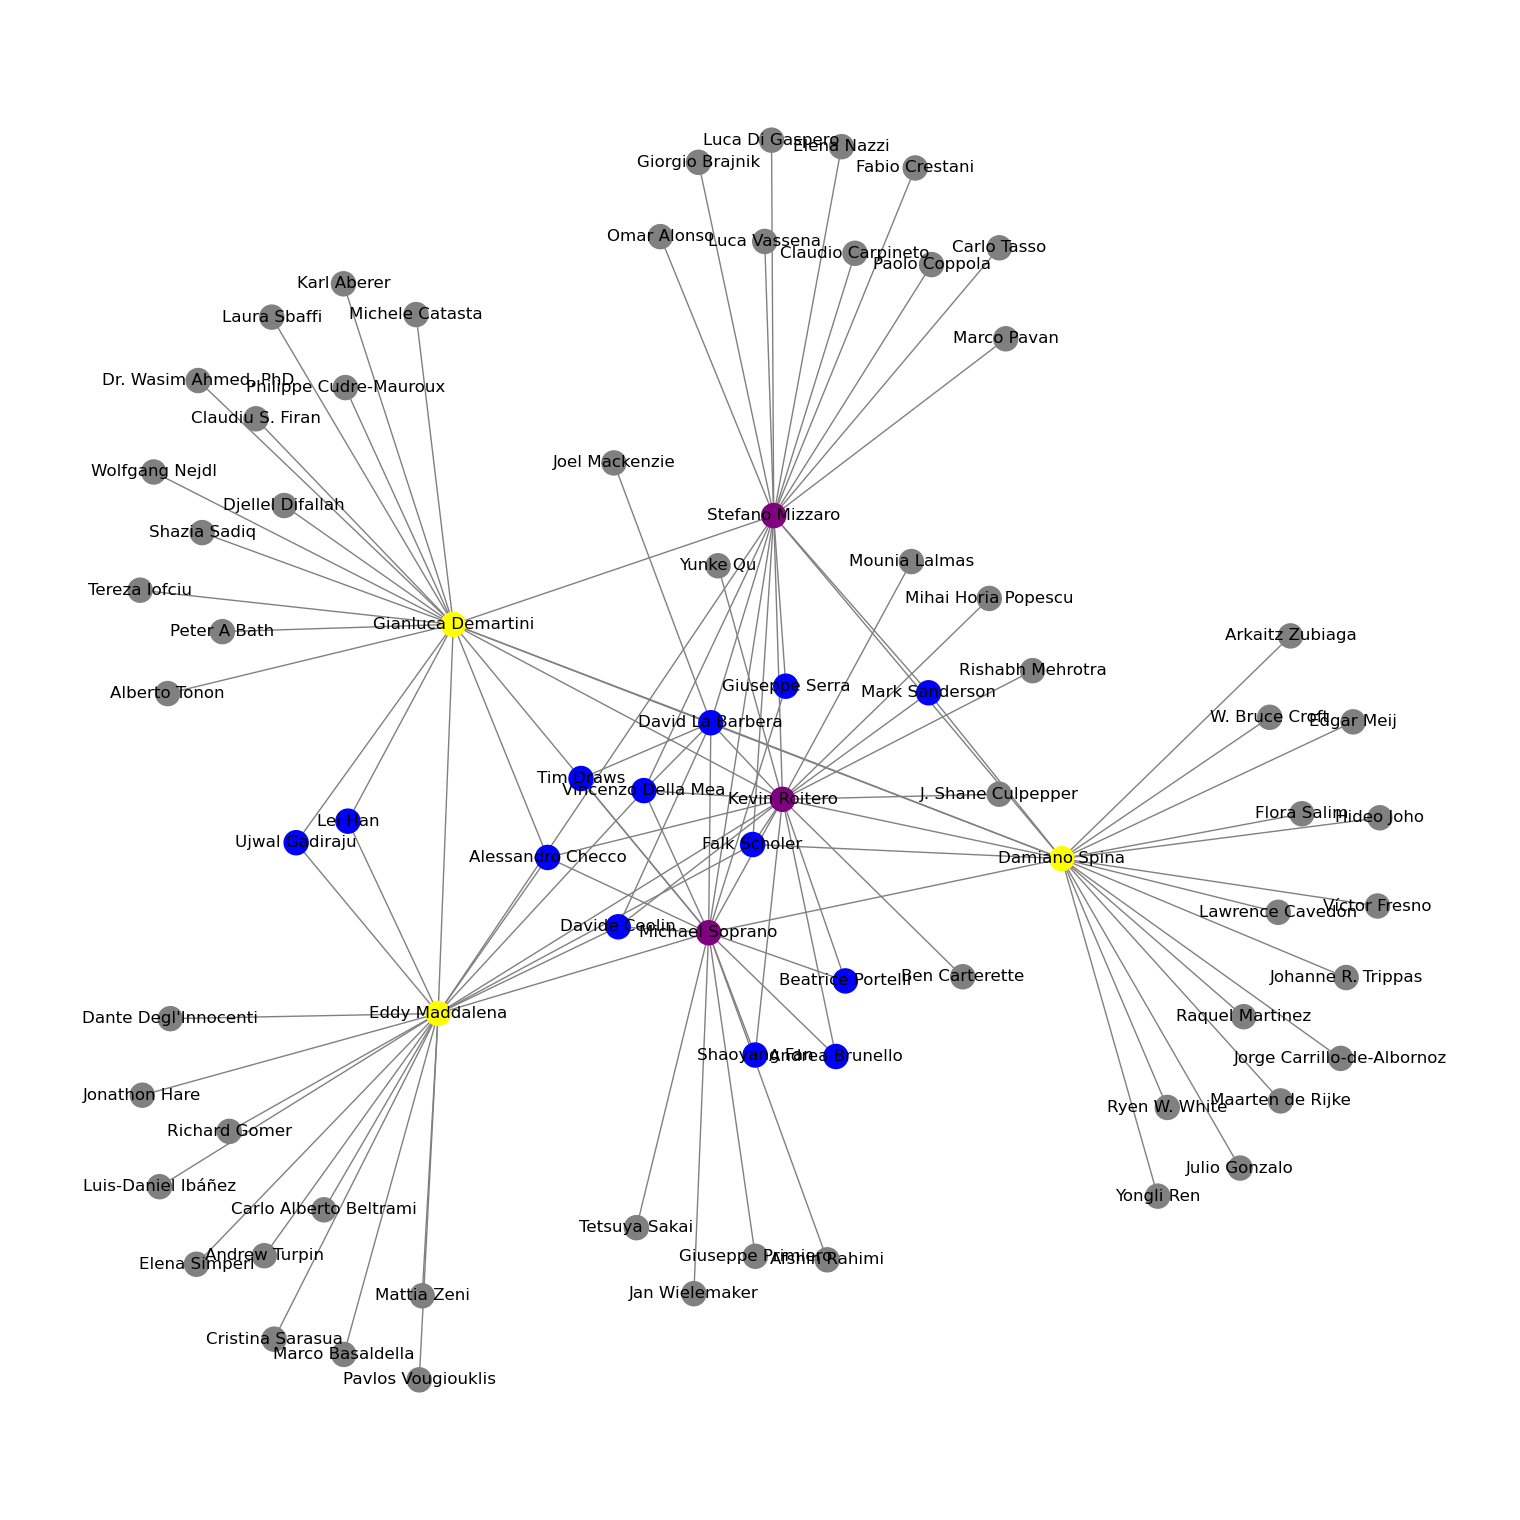

In [18]:
##3.b
## Visualizzare il grafo

## Logica per la gestione dei colori

def Choose_Node_Color(Graph):
        color = {}
    
        for node in Graph.nodes():
                degree= Graph.degree[node]
                if degree == 1:
                        color[node] = 'gray'           
                elif 2 <= degree <= 10:
                        color[node]='blue'
                elif 11 <= degree <= 20:
                        color[node]= 'purple'
                else:
                        color[node]= 'yellow'

        return list(color.values())

plt.figure(figsize=(15, 15))

## Ogni nodo viene aggiunto un attributo "color" (stringa) che ne identifica il colore nel grafico
for node, color in zip(coautorship_graph.nodes(), Choose_Node_Color(coautorship_graph)):
    coautorship_graph.nodes[node]['label'] = str(node)
    coautorship_graph.nodes[node]['color'] = color

## parametri di visualizzazione
nx.draw(coautorship_graph,
        pos=nx.spring_layout(coautorship_graph),
        node_color= [coautorship_graph.nodes[node]['color'] for node in coautorship_graph.nodes],
        edge_color='grey',
        width=1,
        with_labels=True
        )

## Salvataggio del grafo in pdf
plt.savefig("visualizations\\first_graph.pdf")

plt.show()

4. A partire dal grafo prodotto al punto 3:

a. Generarne un secondo dove il numero di nodi è lo stesso, mentre il numero di archi è aumentato di 50 utilizzando la tecnica del Preferential Attachment.
Salvare il grafo in locale nella cartella /graphs.

b. Visualizzare e salvare il nuovo grafo come fatto al punto 3b

In [19]:
##4.a

## Come base viene usato il grafo precedente


extended_coautorship_graph = coautorship_graph.copy()

new_edges_list = list(nx.preferential_attachment(extended_coautorship_graph))

new_edges_list.sort(key= lambda x:x[2], ## ordina in base al valore p di preferential_attachment
                    reverse=True
                    )

new_edges_tuple  = [(item[0], item[1]) for item in new_edges_list[:50]]

extended_coautorship_graph.add_edges_from(new_edges_tuple)

## Salvataggio grafo
with open('graphs\\extended_coauthorship_graph.gpickle', 'wb') as file:
    pickle.dump(extended_coautorship_graph, file)


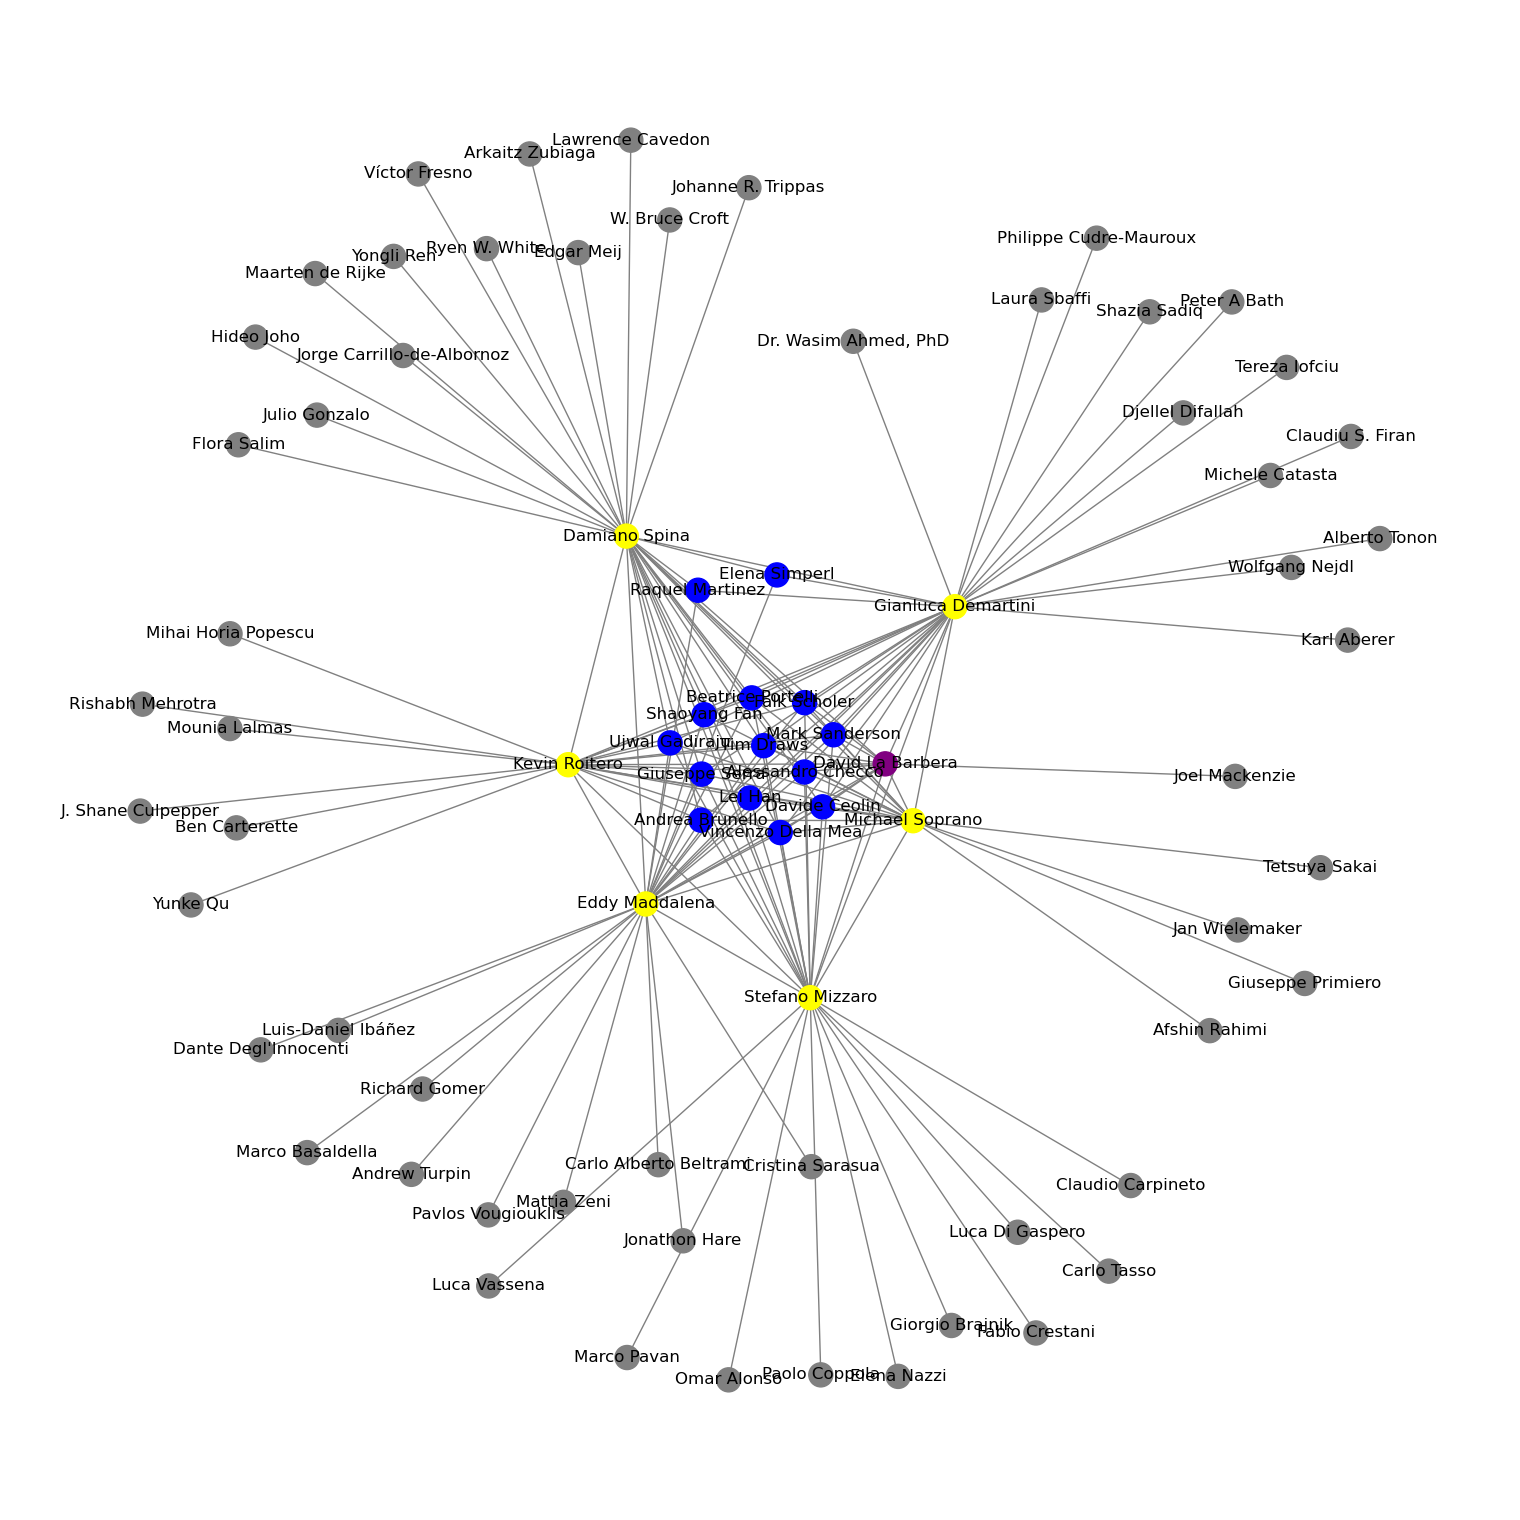

In [20]:
## 4.b

## Stampa del grafo... 
plt.figure(figsize=(15, 15))

## Ogni nodo viene aggiunto un attributo "color" (stringa) che ne identifica il colore nel grafico
for node, color in zip(extended_coautorship_graph.nodes(), Choose_Node_Color(extended_coautorship_graph)):
    extended_coautorship_graph.nodes[node]['label'] = str(node)
    extended_coautorship_graph.nodes[node]['color'] = color

## parametri di visualizzazione
nx.draw(extended_coautorship_graph,
        pos=nx.spring_layout(extended_coautorship_graph),
        node_color= [extended_coautorship_graph.nodes[node]['color'] for node in extended_coautorship_graph.nodes],
        edge_color='grey',
        width=1,
        with_labels=True
        )

## save grafo...
plt.savefig("visualizations\\extended_graph.pdf")

plt.show()

5. Per entrambi i grafi prodotti calcolare:
    - Coefficiente di clustering medio
    - Centro del grafo
    - Raggio
    - Distanza Media
    - Transitività
    - Coefficienti Omega e Sigma, per stimare la “small-world-ness”
    - Riassumere le informazioni in un DataFrame, dove ogni riga rappresenta le informazioni relative ad un grafo, ed ogni colonna le informazioni relative ad una misura calcolata per quel grafo. Salvare nella cartella /results tale DataFrame.


In [21]:
datiGrafo1 = {
    "nome" : "coautorship_graph",
    "clustering_medio": nx.average_clustering(coautorship_graph),
    "centro": ", ".join(nx.center(coautorship_graph)),              # conversione in stringa
    "raggio": nx.radius(coautorship_graph),
    "distanza_media": nx.average_shortest_path_length(coautorship_graph),
    "transitivita": nx.transitivity(coautorship_graph),
    "coeff_omega": nx.omega(coautorship_graph),
    "coeff_sigma": nx.sigma(coautorship_graph)
}

datiGrafo2 = {
    "nome" : "extended_coautorship_graph",
    "clustering_medio": nx.average_clustering(extended_coautorship_graph),
    "centro": ", ".join(nx.center(extended_coautorship_graph)),     # conversione in stringa
    "raggio": nx.radius(extended_coautorship_graph),
    "distanza_media": nx.average_shortest_path_length(extended_coautorship_graph),
    "transitivita": nx.transitivity(extended_coautorship_graph),
    "coeff_omega": nx.omega(extended_coautorship_graph),
    "coeff_sigma": nx.sigma(extended_coautorship_graph)
}

dataFrameGrafo1 = pd.DataFrame(datiGrafo1, index=[0])
dataFrameGrafo2 = pd.DataFrame(datiGrafo2, index=[0])
dfMisure = pd.concat([dataFrameGrafo1, dataFrameGrafo2])
dfMisure.to_csv("results\\overall_measures.csv", index = False)

6. Per entrambi i grafi prodotti calcolare per ogni nodo:
- Degree Centrality
- Betweenness Centrality
- Closeness Centrality
- Pagerank
- HITS, per calcolare i valori di hubness e authority
- Riassumere le due informazioni in un DataFrame per ciascun grafo, dove ogni riga rappresenta le informazioni relative ad un nodo, ed ogni colonna le 
informazioni relative ad una misura calcolata per quel nodo. 
Salvare nella cartella /results tali DataFrame.

In [22]:
#calcolo degli indici in quest'ordine:
#1- degree centrality
#2- betweenness centrality
#3- closeness centrality
#4- page-rank
#5- HITS

degree_centrality_coautorship_graph=nx.degree_centrality(coautorship_graph)
degree_centrality_extended_coautorship_graph=nx.degree_centrality(extended_coautorship_graph)

betweennes_centrality_coautorship_graph=nx.betweenness_centrality(coautorship_graph)
betweennes_centrality_extended_coautorship_graph=nx.betweenness_centrality(extended_coautorship_graph)

closeness_centrality_coautorship_graph=nx.closeness_centrality(coautorship_graph)
closeness_centrality_extended_coautorship_graph=nx.closeness_centrality(extended_coautorship_graph)

page_rank_coautorship_graph=nx.pagerank(coautorship_graph)
page_rank_extended_coautorship_graph=nx.pagerank(extended_coautorship_graph)

hits_coautorship_graph=nx.hits(coautorship_graph)
hits_extended_coautorship_graph=nx.hits(extended_coautorship_graph)

hubs_coautorship,authorities_coautorship=hits_coautorship_graph
hubs_extended_coautorship,authorities_extended_coautorship=hits_extended_coautorship_graph

#creazione dei dataframe
coautorship = {
    'Nodi' : degree_centrality_coautorship_graph.keys(),
    'Degree Centrality' : degree_centrality_coautorship_graph.values(),
    'Betweenness Centrality' : betweennes_centrality_coautorship_graph.values(),
    'Closeness Centrality' : closeness_centrality_coautorship_graph.values(),
    'Page Rank' : page_rank_coautorship_graph.values(),
    'HITS Hubs' : hubs_coautorship.values(),
    'HITS Authorities' : authorities_coautorship.values()
}

coauthorship_df = pd.DataFrame(coautorship)

extended_coauthorship = {
    'Nodi' : degree_centrality_extended_coautorship_graph.keys(),
    'Degree Centrality' : degree_centrality_extended_coautorship_graph.values(),
    'Betweenness Centrality' : betweennes_centrality_extended_coautorship_graph.values(),
    'Closeness Centrality' : closeness_centrality_extended_coautorship_graph.values(),
    'Page Rank' : page_rank_extended_coautorship_graph.values(),
    'HITS Hubs' : hubs_extended_coautorship.values(),
    'HITS Authorities' : authorities_extended_coautorship.values()

}

coauthorship_extended_df = pd.DataFrame(extended_coauthorship)

display(coauthorship_df)
display(coauthorship_extended_df)

#creazione dei file
coauthorship_df.to_csv("results\\first_graph_centralities.csv", index = False)
coauthorship_extended_df.to_csv("results\\extended_graph_centralities.csv", index = False)

#------------------------------------------------------------------------------------
#Calcolo valori massimi/minimi/medie coauthorship/extended coauthorship
maxValuesCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_df['Nodi'].iloc[coauthorship_df['Degree Centrality'].idxmax()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Betweenness Centrality'].idxmax()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['Closeness Centrality'].idxmax()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Page Rank'].idxmax()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Hubs'].idxmax()] , coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Authorities'].idxmax()]],
    'Valore' : [coauthorship_df['Degree Centrality'].max() , coauthorship_df['Betweenness Centrality'].max() , coauthorship_df['Closeness Centrality'].max() , coauthorship_df['Page Rank'].max() , 
                coauthorship_df['HITS Hubs'].max() , coauthorship_df['HITS Authorities'].max()]
}

maxValuesExtendedCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Degree Centrality'].idxmax()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Betweenness Centrality'].idxmax()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Closeness Centrality'].idxmax()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Page Rank'].idxmax()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Hubs'].idxmax()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Authorities'].idxmax()]],
    'Valore' : [coauthorship_extended_df['Degree Centrality'].max() , coauthorship_extended_df['Betweenness Centrality'].max() , coauthorship_extended_df['Closeness Centrality'].max() , coauthorship_extended_df['Page Rank'].max() , 
                coauthorship_extended_df['HITS Hubs'].max() , coauthorship_extended_df['HITS Authorities'].max()]
}

minValuesCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_df['Nodi'].iloc[coauthorship_df['Degree Centrality'].idxmin()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Betweenness Centrality'].idxmin()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['Closeness Centrality'].idxmin()] , coauthorship_df['Nodi'].iloc[coauthorship_df['Page Rank'].idxmin()] , 
              coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Hubs'].idxmin()] , coauthorship_df['Nodi'].iloc[coauthorship_df['HITS Authorities'].idxmin()]],
    'Valore' : [coauthorship_df['Degree Centrality'].min() , coauthorship_df['Betweenness Centrality'].min() , coauthorship_df['Closeness Centrality'].min() , coauthorship_df['Page Rank'].min() , 
                coauthorship_df['HITS Hubs'].min() , coauthorship_df['HITS Authorities'].min()]
}

minValuesExtendedCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Nodo' : [coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Degree Centrality'].idxmin()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Betweenness Centrality'].idxmin()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Closeness Centrality'].idxmin()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['Page Rank'].idxmin()] , 
              coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Hubs'].idxmin()] , coauthorship_extended_df['Nodi'].iloc[coauthorship_extended_df['HITS Authorities'].idxmin()]],
    'Valore' : [coauthorship_extended_df['Degree Centrality'].min() , coauthorship_extended_df['Betweenness Centrality'].min() , coauthorship_extended_df['Closeness Centrality'].min() , coauthorship_extended_df['Page Rank'].min() , 
                coauthorship_extended_df['HITS Hubs'].min() , coauthorship_extended_df['HITS Authorities'].min()]
}

meanValuesCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Medie' : [coauthorship_df['Degree Centrality'].mean() , coauthorship_df['Betweenness Centrality'].mean() , coauthorship_df['Closeness Centrality'].mean() , coauthorship_df['Page Rank'].mean(),
               coauthorship_df['HITS Hubs'].mean() , coauthorship_df['HITS Authorities'].mean()]
}

meanValuesExtendedCoauthorship = {
    'Indici' : ['Degree Centrality' , 'Betweenness Centrality' , 'Closeness Centrality' , 'Page Rank' , 'HITS Hubs' , 'HITS Authorities'],
    'Medie' : [coauthorship_extended_df['Degree Centrality'].mean() , coauthorship_extended_df['Betweenness Centrality'].mean() , coauthorship_extended_df['Closeness Centrality'].mean(), 
               coauthorship_extended_df['Page Rank'].mean() , coauthorship_extended_df['HITS Hubs'].mean() , coauthorship_extended_df['HITS Authorities'].mean()]
}

maxValuesCoauthorshipDF = pd.DataFrame(maxValuesCoauthorship)
maxValuesExtendedCoauthorshipDF = pd.DataFrame(maxValuesExtendedCoauthorship)
minValuesCoauthorshipDF = pd.DataFrame(minValuesCoauthorship) 
minValuesExtendedCoauthorshipDF = pd.DataFrame(minValuesExtendedCoauthorship)
meanValuesCoauthorshipDF = pd.DataFrame(meanValuesCoauthorship)
meanValuesExtendedCoauthorshipDF = pd.DataFrame(meanValuesExtendedCoauthorship)


print("MAX VALUES COAUTHORSHIP")
display(maxValuesCoauthorshipDF)
print("MAX VALUES EXTENDED COAUTHORSHIP")
display(maxValuesExtendedCoauthorshipDF)
print("MIN VALUES COAUTHORSHIP")
display(minValuesCoauthorshipDF)
print("MIN VALUES EXTENDED COAUTHORSHIP")
display(minValuesExtendedCoauthorshipDF)
print("MEAN VALUES COAUTHORSHIP")
display(meanValuesCoauthorshipDF)
print("MEAN VALUES EXTENDED COAUTHORSHIP")
display(meanValuesExtendedCoauthorshipDF)




,Nodi,Degree Centrality,Betweenness Centrality,Closeness Centrality,Page Rank,HITS Hubs,HITS Authorities
0,David La Barbera,0.118421,0.041472,0.493506,0.033962,0.043602,0.043602
1,Michael Soprano,0.236842,0.183715,0.567164,0.068649,0.061101,0.061101
2,Kevin Roitero,0.263158,0.217404,0.575758,0.077408,0.065161,0.065161
3,Stefano Mizzaro,0.263158,0.280621,0.575758,0.083447,0.058554,0.058554
4,Damiano Spina,0.276316,0.341118,0.535211,0.094812,0.049063,0.049063
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.343891,0.005532,0.006373,0.006373
73,Pavlos Vougiouklis,0.013158,0.000000,0.343891,0.005532,0.006373,0.006373
74,Jonathon Hare,0.013158,0.000000,0.343891,0.005532,0.006373,0.006373
75,Carlo Alberto Beltrami,0.013158,0.000000,0.343891,0.005532,0.006373,0.006373


,Nodi,Degree Centrality,Betweenness Centrality,Closeness Centrality,Page Rank,HITS Hubs,HITS Authorities
0,David La Barbera,0.171053,0.027068,0.546763,0.033802,0.041141,0.041141
1,Michael Soprano,0.289474,0.107594,0.584615,0.058629,0.053843,0.053843
2,Kevin Roitero,0.315789,0.157068,0.593750,0.066102,0.054483,0.054483
3,Stefano Mizzaro,0.368421,0.251805,0.612903,0.081736,0.055810,0.055810
4,Damiano Spina,0.434211,0.327945,0.638655,0.099134,0.059027,0.059027
...,...,...,...,...,...,...,...
72,Dante Degl'Innocenti,0.013158,0.000000,0.385787,0.004413,0.004560,0.004560
73,Pavlos Vougiouklis,0.013158,0.000000,0.385787,0.004413,0.004560,0.004560
74,Jonathon Hare,0.013158,0.000000,0.385787,0.004413,0.004560,0.004560
75,Carlo Alberto Beltrami,0.013158,0.000000,0.385787,0.004413,0.004560,0.004560


MAX VALUES COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Damiano Spina,0.276316
1,Betweenness Centrality,Damiano Spina,0.341118
2,Closeness Centrality,Gianluca Demartini,0.580153
3,Page Rank,Damiano Spina,0.094812
4,HITS Hubs,Kevin Roitero,0.065161
5,HITS Authorities,Kevin Roitero,0.065161


MAX VALUES EXTENDED COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Damiano Spina,0.434211
1,Betweenness Centrality,Damiano Spina,0.327945
2,Closeness Centrality,Damiano Spina,0.638655
3,Page Rank,Damiano Spina,0.099134
4,HITS Hubs,Damiano Spina,0.059027
5,HITS Authorities,Damiano Spina,0.059027


MIN VALUES COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Joel Mackenzie,0.013158
1,Betweenness Centrality,Tim Draws,0.000000
2,Closeness Centrality,Joel Mackenzie,0.331878
3,Page Rank,Joel Mackenzie,0.005156
4,HITS Hubs,Joel Mackenzie,0.005184
5,HITS Authorities,Joel Mackenzie,0.005184


MIN VALUES EXTENDED COAUTHORSHIP


,Indici,Nodo,Valore
0,Degree Centrality,Joel Mackenzie,0.013158
1,Betweenness Centrality,Vincenzo Della Mea,0.000000
2,Closeness Centrality,Joel Mackenzie,0.355140
3,Page Rank,Joel Mackenzie,0.004158
4,HITS Hubs,Joel Mackenzie,0.003237
5,HITS Authorities,Joel Mackenzie,0.003237


MEAN VALUES COAUTHORSHIP


,Indici,Medie
0,Degree Centrality,0.037936
1,Betweenness Centrality,0.022096
2,Closeness Centrality,0.382916
3,Page Rank,0.012987
4,HITS Hubs,0.012987
5,HITS Authorities,0.012987


MEAN VALUES EXTENDED COAUTHORSHIP


,Indici,Medie
0,Degree Centrality,0.055024
1,Betweenness Centrality,0.018674
2,Closeness Centrality,0.427338
3,Page Rank,0.012987
4,HITS Hubs,0.012987
5,HITS Authorities,0.012987


7. Produrre una visualizzazione interattiva con PyVis dei due grafi con colorazioni di
nodi ed archi a piacimento. Salvare i due output in formato HTML nella cartella
/visualizations.

In [23]:
## Save grafo interattivo

## Creazione grafo con area di stampa
interactive_first_graph= pv.network.Network(height= '600px', 
                       width='100%')
    
## Conversione per Pyvis
interactive_first_graph.from_nx(coautorship_graph)
interactive_first_graph.save_graph('visualizations\\interactive_first_graph.html')

####################################
## Ripeti sopra per secondo grafo...
interactive_extended_graph= pv.network.Network(height= '600px', 
                       width='100%')


interactive_extended_graph.from_nx(extended_coautorship_graph)
interactive_extended_graph.save_graph('visualizations\\interactive_extended_graph.html')

Analisi comparativa reti

(array([58., 12.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  3.]),
 array([0.01315789, 0.05526316, 0.09736842, 0.13947368, 0.18157895,
        0.22368421, 0.26578947, 0.30789474, 0.35      , 0.39210526,
        0.43421053]),
 <BarContainer object of 10 artists>)

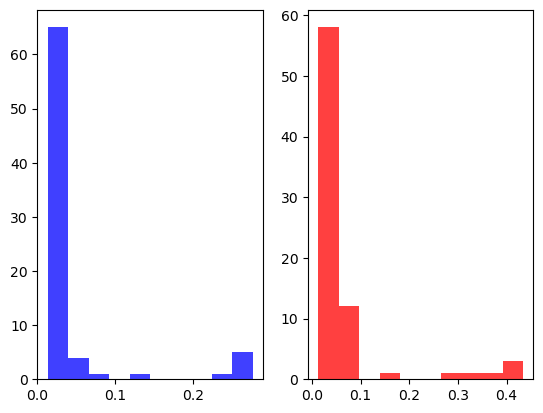

In [24]:
## Degree Centrality

plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['Degree Centrality'], 
         alpha=0.75,
         bins=10,
         color='blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['Degree Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'red')


(array([71.,  0.,  0.,  1.,  1.,  0.,  0.,  2.,  0.,  2.]),
 array([0.        , 0.03279449, 0.06558897, 0.09838346, 0.13117794,
        0.16397243, 0.19676692, 0.2295614 , 0.26235589, 0.29515038,
        0.32794486]),
 <BarContainer object of 10 artists>)

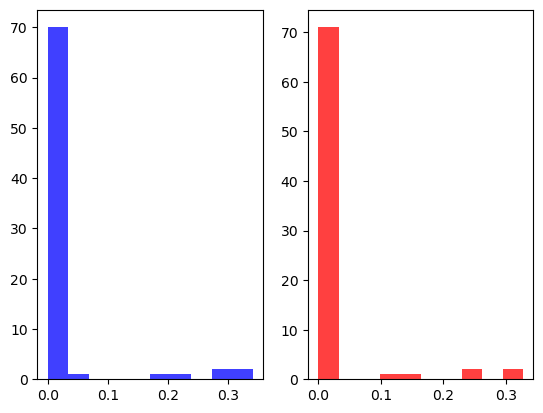

In [25]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['Betweenness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['Betweenness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([21., 35.,  0.,  2.,  0., 12.,  1.,  0.,  2.,  4.]),
 array([0.35514019, 0.38349171, 0.41184324, 0.44019477, 0.4685463 ,
        0.49689782, 0.52524935, 0.55360088, 0.58195241, 0.61030393,
        0.63865546]),
 <BarContainer object of 10 artists>)

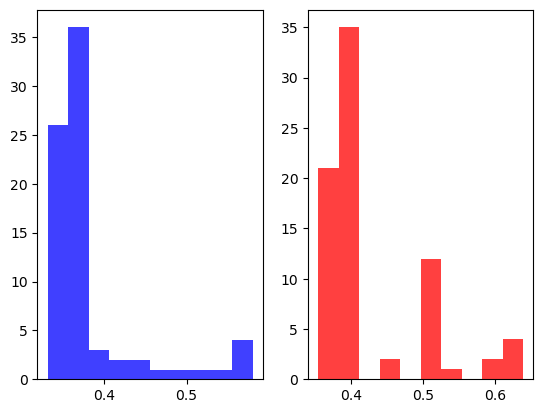

In [26]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['Closeness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['Closeness Centrality'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([56.,  2.,  0.,  0., 12.,  0.,  1.,  0.,  0.,  6.]),
 array([0.00323724, 0.00881625, 0.01439526, 0.01997428, 0.02555329,
        0.0311323 , 0.03671132, 0.04229033, 0.04786934, 0.05344836,
        0.05902737]),
 <BarContainer object of 10 artists>)

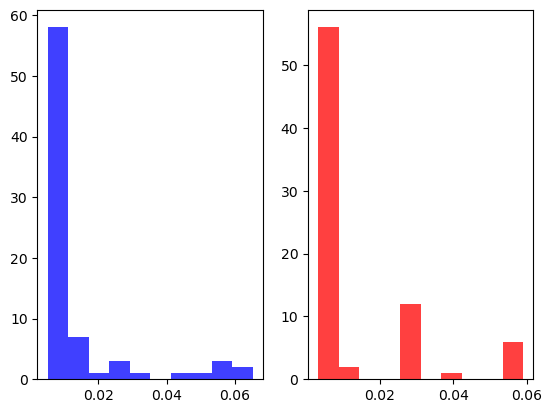

In [27]:

plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([56.,  2.,  0.,  0., 12.,  0.,  1.,  0.,  0.,  6.]),
 array([0.00323724, 0.00881625, 0.01439526, 0.01997428, 0.02555329,
        0.0311323 , 0.03671132, 0.04229033, 0.04786934, 0.05344836,
        0.05902737]),
 <BarContainer object of 10 artists>)

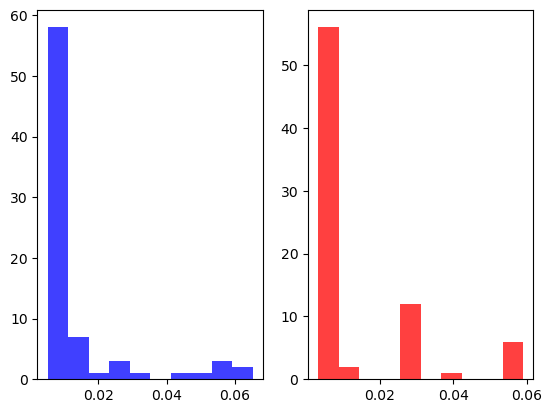

In [28]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['HITS Hubs'], 
         alpha=0.75,
         bins=10,
         color= 'red')

(array([56.,  2.,  0.,  0., 12.,  0.,  1.,  0.,  0.,  6.]),
 array([0.00323724, 0.00881625, 0.01439526, 0.01997428, 0.02555329,
        0.0311323 , 0.03671132, 0.04229033, 0.04786934, 0.05344836,
        0.05902737]),
 <BarContainer object of 10 artists>)

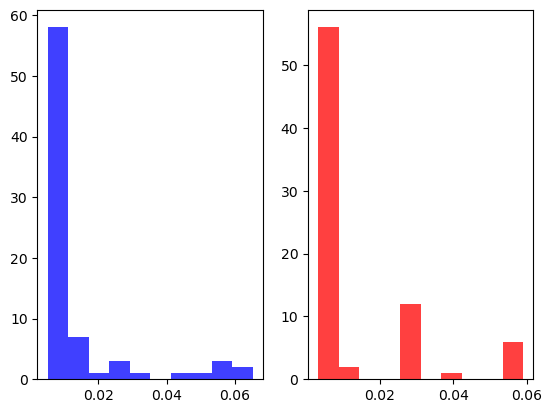

In [29]:
plt.subplot(1, 2, 1)
plt.hist(coauthorship_df['HITS Authorities'], 
         alpha=0.75,
         bins=10,
         color= 'blue')

plt.subplot(1, 2, 2)
plt.hist(coauthorship_extended_df['HITS Authorities'], 
         alpha=0.75,
         bins=10,
         color= 'red')